# A [simple] CNN for Image Classification

As described in the `README`, we will begin with a simple CNN that classifies a single image as belong to a cheap, average, or expensive house. The model architecture is reproduced below:

| Layer | Input Dimensions | Output Dimensions | Objective | Activation Function | In Channels | Out Channels | Kernel | Stride | Padding |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------| 
| Convolutional Layer 1 | 224, 224, 3 | 224, 224, 32 | Learn spatial features | ReLU | 3 | 32 | 3 | 1 | 1
| Pooling Layer 1 | 224, 224, 32 | 112, 112, 32 | Down-sampling | | 32 | 32 | 2 | 2 | 0
| Convolutional Layer 2 | 112, 112, 32 | 112, 112, 64 | Learn spatial features | ReLU | 32 | 64 | 3 | 1 | 1
| Pooling Layer 2 | 112, 112, 64 | 56, 56, 64 | Down-sampling | | 64 | 64 | 2 | 2 | 0
| Dense Layer 1 | 200704 | 512 | Learn spatial features | ReLU | 200704 | 512 | | | |
| Dense Layer 2 | 512 | 3 | Classification | Softmax | 512 | 3 | | | |

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from src.preprocessing import get_housing_dataset
from src.logging import get_logger

logger = get_logger(__name__)

%load_ext autoreload
%autoreload 2

In [2]:
# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=3, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=3, stride=1, padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(512, 3)  # output layer

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor for the dense layer
        x = self.dropout1(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)  # No activation function here as CrossEntropyLoss will be used
        return x

In [3]:
dataset = get_housing_dataset()

# Create indices for the full dataset and split them
indices = list(range(len(dataset)))
train_indices, val_indices, _, _ = train_test_split(
    indices, indices, test_size=0.2, random_state=42
)

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=4, shuffle=True, num_workers=0)

In [4]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)  # TODO try a higher weight decay
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Run a training epoch
        model.train()
        running_loss = 0.0
        running_training_accuracy = 0.0
        running_validation_accuracy = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Make prediction
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights

            # Compute loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_training_accuracy += accuracy_score(
                labels.numpy(), predicted.numpy()
            )

        # Compare to validation accuracy,
        # this slows things down but is useful for understanding
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                running_validation_accuracy += accuracy_score(
                    labels.numpy(), predicted.numpy()
                )

        logger.info(
            f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.2f}, "
            f"Training Accuracy: {running_training_accuracy/len(train_loader):.2f}, "
            f"Validation Accuracy: {running_validation_accuracy/len(val_loader):.2f}"
        )

        losses.append(running_loss/len(train_loader))
        train_accuracies.append(running_training_accuracy/len(train_loader))
        val_accuracies.append(running_validation_accuracy/len(val_loader))

    return losses, train_accuracies, val_accuracies

# TODO make this work on a GPU and use Google colab?

# Example training call (assuming train_loader is defined)
losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer)

2024-02-19 23:26:31,558 [INFO]: Epoch 1, Loss: 1.11, Training Accuracy: 0.36, Validation Accuracy: 0.37
2024-02-19 23:30:01,399 [INFO]: Epoch 2, Loss: 1.07, Training Accuracy: 0.42, Validation Accuracy: 0.37
2024-02-19 23:33:37,925 [INFO]: Epoch 3, Loss: 1.03, Training Accuracy: 0.46, Validation Accuracy: 0.42
2024-02-19 23:37:19,475 [INFO]: Epoch 4, Loss: 0.99, Training Accuracy: 0.53, Validation Accuracy: 0.42
2024-02-19 23:40:53,067 [INFO]: Epoch 5, Loss: 0.93, Training Accuracy: 0.56, Validation Accuracy: 0.44
2024-02-19 23:44:14,222 [INFO]: Epoch 6, Loss: 0.89, Training Accuracy: 0.61, Validation Accuracy: 0.47
2024-02-19 23:47:38,954 [INFO]: Epoch 7, Loss: 0.82, Training Accuracy: 0.65, Validation Accuracy: 0.45
2024-02-19 23:51:09,193 [INFO]: Epoch 8, Loss: 0.77, Training Accuracy: 0.69, Validation Accuracy: 0.45
2024-02-19 23:54:42,528 [INFO]: Epoch 9, Loss: 0.71, Training Accuracy: 0.73, Validation Accuracy: 0.45
2024-02-19 23:58:31,346 [INFO]: Epoch 10, Loss: 0.65, Training A

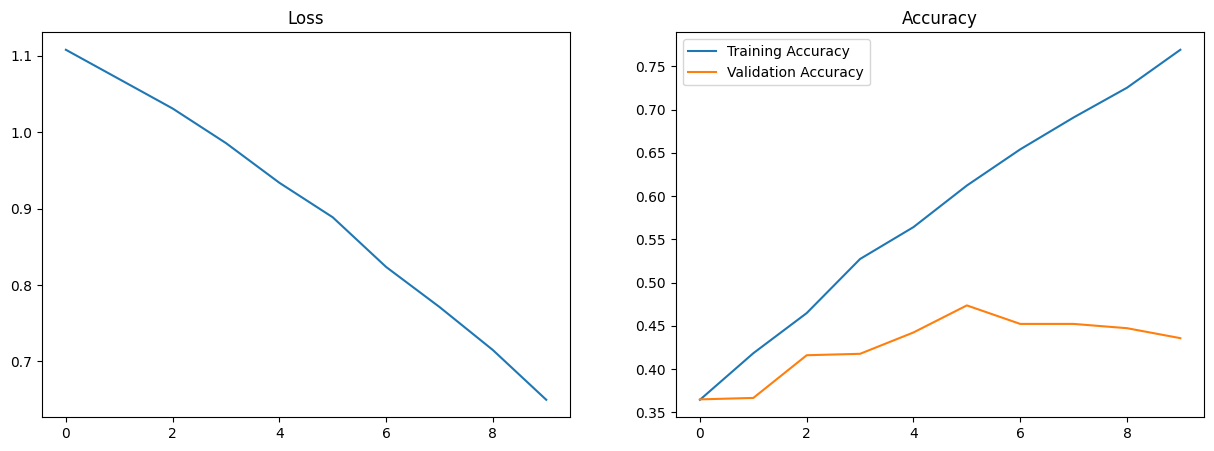

In [5]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses)
ax[0].set_title("Loss")
ax[1].plot(train_accuracies, label="Training Accuracy")
ax[1].plot(val_accuracies, label="Validation Accuracy")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

# Overfitting

We interrupted the previous training block because the model has clearly just started to massively overfit to the training data, with marginal (or even negative) returns on the validation accuracy. So what can we do to reduce overfitting and ideally attain better validation accuracies?

- Dropout regularization: we will add dropout layers before the dense layers to reduce overfitting (dropout of 50% seemed to high so lowered to 20%) - moderate improvement
- Lower the learning rate (not enough epochs for decay scheduling) - major improvement!
- Add weight decay - doesn't seem to be helping much right now?
- Increasing training set size by using each image as its own data point (not just one image per property).

Progress so far: started at around 33% validation accuracy, up to a max of 47%.

*Notice that we are using accuracy as our score because our labels are perfectly balanced, so we don't need to worry about precision, recall, f1 scores, and all that jazz.*

In [6]:
# TODO check the shape of the NN's outputs. Are they converging to [0.33, 0.33, 0.33] for most predictions?
# If so then the model is not learning anything meaningful, and we need a different architecture on the output
# layer or a different loss function.
# TODO data augmentation!

In [ ]:
def predict(model, val_loader):
    model.eval()
    predictions = []
    with torch.no_grad():  # Don't waste resources on gradients
        for images, _ in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions


predictions = predict(model, val_loader)

In [ ]:
# TODO hyperparameter tuning